In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
import scipy
#from numpy.linalg import svd
import gseapy as gp

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), 'Documents/git/Xct'))

    from scTenifoldXct.main import *
    import scTenifoldXct.dNN as dNN    
    import scTenifoldXct.visualization as vis
    
except ImportError:
    print('Module not found')

In [3]:
ada = sc.read_h5ad("../data/lung_processed.h5ad")
ada

AnnData object with n_obs × n_vars = 4356 × 3000
    obs: 'cell_well', 'batch', 'n_genes', 'leiden', 'cell_type', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells'
    uns: 'batch_colors', 'cell_type_colors', 'ident_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p', 'raw'
    obsp: 'connectivities', 'distances'

In [4]:
ada.obs['ident'].value_counts()

Basophil_KO                 1284
Basophil_WT                 1152
Macrophage2                  489
Neutrophil                   315
Endothelium                  294
Matrix fibroblast            154
AT1                          117
Smooth muscle fibroblast     110
Macrophage1                  101
T cell                        97
AT2                           92
Basophil                      82
B cell                        69
Name: ident, dtype: int64

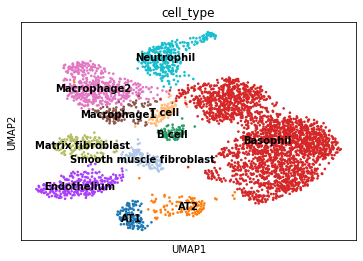

In [5]:
sc.pl.umap(ada, color='cell_type', legend_loc='on data')

## WT & KO obj:

In [9]:
# obj1 = Xct(ada, 'AT2', 'Basophil_WT', build_GRN = True, save_GRN = True, 
#            pcNet_name = 'net_AT2Baso_WT', mode = 'full', verbose = True)

obj1 = Xct(ada, 'AT2', 'Basophil_WT', specis='Mouse' ,build_GRN = False,
           pcNet_name = 'net_AT2Baso_WT', mode = 'full', verbose = True)

print(obj1)

init an Xct object for interactions from AT2 (92) to Basophil_WT (1152)...
loading GRNs...
building correspondence...
init completed.

Xct object for interactions from AT2 (92) to Basophil_WT (1152)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [10]:
df1 = obj1.fill_metric()
len(df1)

785

In [11]:
# obj2 = Xct(ada, 'AT2', 'Basophil_KO', build_GRN = True, save_GRN = True,
#            pcNet_name = 'net_AT2Baso_KO', mode = 'full', verbose = True)

obj2 = Xct(ada, 'AT2', 'Basophil_KO', specis = 'Mouse', build_GRN = False,
           pcNet_name = 'net_AT2Baso_KO', mode = 'full', verbose = True)

print(obj2)

init an Xct object for interactions from AT2 (92) to Basophil_KO (1284)...
loading GRNs...
building correspondence...
init completed.

Xct object for interactions from AT2 (92) to Basophil_KO (1284)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [12]:
df2 = obj2.fill_metric()
len(df2)

720

In [13]:
df1[df1.ligand == 'Il33']

,ligand,receptor,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R
1259,Il33,Egfr,0.277324,0.005270,0.393009,0.006468,1.417148,1.227227,2.260549,15.259525,0.021207,-0.108662
7503,Il33,Il1rl1,0.277324,0.518603,0.393009,0.970821,1.417148,1.871994,2.260549,1.899918,0.021207,-0.083371


In [14]:
df2[df2.ligand == 'Il33']

,ligand,receptor,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R


In [15]:
#selected LR pairs
candidates1 = get_candidates(df1)
print(len(candidates1))

candidates2 = get_candidates(df2)
print(len(candidates2))

785
720


In [16]:
candidates_union = list(set(candidates1).union(set(candidates2)))
len(candidates_union)

817

In [17]:
candidates_inter = list(set(candidates1).intersection(set(candidates2)))
len(candidates_inter)

688

In [18]:
obj1._w.shape, obj2._w.shape

((6000, 6000), (6000, 6000))

1:

In [43]:
counts_np1 = get_counts_np(obj1)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape

(2, (3000, 92), (3000, 1152))

In [44]:
projections1, losses1 = dNN.train_and_project(counts_np1, obj1._w, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=92, out_features=52, bias=True)
  (linear2): Linear(in_features=52, out_features=13, bias=True)
  (linear3): Linear(in_features=13, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=1152, out_features=192, bias=True)
  (linear2): Linear(in_features=192, out_features=48, bias=True)
  (linear3): Linear(in_features=48, out_features=2, bias=True)
)
1 7632.52001953125
100 1038.3546142578125
200 1023.1007690429688
300 1020.2066040039062
400 1019.0499877929688
500 1018.4647216796875
600 1018.09912109375
700 1017.7987060546875
800 1017.5791625976562
900 1017.5626220703125
1000 1017.4286499023438


In [45]:
df_nn1 = nn_aligned_dist(obj1, projections1)
df_nn1

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
Chi3l1_Serpinb1a,"(89, 258)",0.000002,1,46.286942
Klf6_Il4,"(2870, 1106)",0.000002,2,36.579487
Acsl4_Cdkn1a,"(2912, 1418)",0.000004,3,33.142555
Cldn3_Cst7,"(339, 1871)",0.000005,4,34.522434
Ces1d_Mkrn1,"(207, 343)",0.000005,5,38.234234
...,...,...,...,...
Acvr1b_Lgi2,"(1296, 1498)",0.035599,8999996,0.000000
Acvr1b_Flnc,"(1296, 1499)",0.035599,8999997,0.000000
2700038G22Rik_Nthl1,"(2367, 1411)",0.035599,8999998,0.000000
Prtn3_Nthl1,"(327, 1411)",0.035599,8999999,0.000000


In [51]:
df_enriched1 = chi2_test(df_nn1, df = 3, pval = 0.05, FDR = True, candidates = candidates1)

df_enriched1


Total enriched: 12 / 9000000


,idx,dist,rank,correspondence_score,q_val,enriched_rank
Icam1_Itgam,"(461, 2567)",0.000317,6885,40.578003,0.000736,1
Cyr61_Itgam,"(126, 2567)",0.000548,12101,29.591990,0.002164,2
Vegfa_Csf1,"(93, 1041)",0.000549,12114,57.643120,0.002169,3
Thbs1_Itgb7,"(121, 2084)",0.001024,22635,27.055183,0.007535,4
Hp_Itgam,"(1579, 2567)",0.001077,23894,22.236788,0.008315,5
Lamc1_Itgb7,"(2127, 2084)",0.001160,25721,20.456028,0.009641,6
Icam1_Spn,"(461, 2440)",0.001777,40226,16.114262,0.022163,7
Lamb3_Itgb7,"(1093, 2084)",0.001848,42013,19.798346,0.023875,8
S100a8_Cd69,"(10, 216)",0.002149,49466,26.785606,0.031832,9
Lamb1_Itgb7,"(1251, 2084)",0.002223,51456,18.945402,0.033883,10


2:

In [47]:
counts_np2 = get_counts_np(obj2)
len(counts_np2), counts_np2[0].shape, counts_np2[1].shape

(2, (3000, 92), (3000, 1284))

In [48]:
projections2, losses2 = dNN.train_and_project(counts_np2, obj2._w, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=92, out_features=52, bias=True)
  (linear2): Linear(in_features=52, out_features=13, bias=True)
  (linear3): Linear(in_features=13, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=1284, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=2, bias=True)
)
1 6322.44921875
100 973.3917236328125
200 962.82080078125
300 960.5864868164062
400 959.8466796875
500 959.5130615234375
600 960.7017822265625
700 959.2081298828125
800 959.1529541015625
900 959.6240234375
1000 959.3846435546875


In [49]:
df_nn2 = nn_aligned_dist(obj2, projections2)
df_nn2

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
Pi4k2b_C3ar1,"(689, 2305)",7.833641e-07,1,44.005379
Lmo7_H2afy,"(75, 2238)",1.932894e-06,2,47.355171
Ces1d_Gstm1,"(207, 2118)",2.453547e-06,3,46.151749
Lamp3_H2-Oa,"(76, 1241)",6.036380e-06,4,66.550606
Tpm1_Serpinb1a,"(898, 258)",6.865606e-06,5,49.811893
...,...,...,...,...
Cenpn_Nrtn,"(1602, 547)",3.468252e-02,8999996,0.000000
Cenpn_Galntl1,"(1602, 544)",3.468252e-02,8999997,0.000000
Cenpn_Fam70a,"(1602, 539)",3.468252e-02,8999998,0.000000
Cenpn_Adamts12,"(1602, 742)",3.468252e-02,8999999,0.000000


In [52]:
df_enriched2 = chi2_test(df_nn2, df = 3, pval = 0.05, FDR = True, candidates = candidates2)

df_enriched2


Total enriched: 11 / 9000000


,idx,dist,rank,correspondence_score,q_val,enriched_rank
Icam1_Itgam,"(461, 2567)",0.000244,4428,51.072063,0.000520,1
Vegfa_Csf1,"(93, 1041)",0.000615,11416,73.320915,0.003216,2
Cyr61_Itgam,"(126, 2567)",0.000706,13153,37.244904,0.004223,3
Icam1_Spn,"(461, 2440)",0.000745,13912,28.091064,0.004687,4
Thbs1_Itgb7,"(121, 2084)",0.000951,17887,36.603661,0.007573,5
Lamc1_Itgb7,"(2127, 2084)",0.001055,19934,27.675491,0.009278,6
Hp_Itgam,"(1579, 2567)",0.001109,21024,27.987541,0.010233,7
Lamb3_Itgb7,"(1093, 2084)",0.001475,28304,26.785696,0.017854,8
Muc1_Lgals3,"(135, 611)",0.001848,36085,288.481934,0.027544,9
Lamb1_Itgb7,"(1251, 2084)",0.002091,41136,25.631725,0.034968,10


merged:

In [19]:
counts_np1 = get_counts_np(obj1, obj2)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape, counts_np1[2].shape, counts_np1[3].shape

(4, (3000, 92), (3000, 1152), (3000, 92), (3000, 1284))

In [20]:
W = build_W(obj1, obj2)
W.shape

(12000, 12000)

In [21]:
projections, losses = dNN.train_and_project(counts_np1, w = W, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=92, out_features=52, bias=True)
  (linear2): Linear(in_features=52, out_features=13, bias=True)
  (linear3): Linear(in_features=13, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=1152, out_features=192, bias=True)
  (linear2): Linear(in_features=192, out_features=48, bias=True)
  (linear3): Linear(in_features=48, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=92, out_features=52, bias=True)
  (linear2): Linear(in_features=52, out_features=13, bias=True)
  (linear3): Linear(in_features=13, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=1284, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=2, bias=True)
)
1 13557.9423828125
100 1028.9166259765625
200 1006.5384521484375
300 1001.6767578125
400 1000.4012451171875
500 1000.07763671875
600 1000.130615234375
700 999.968017578125
800 998.7056884765625
900 10

In [22]:
projections.shape

(12000, 2)

In [23]:
projections_split = np.array_split(projections, 2) #return a list of ndarray
projections_split[0].shape, projections_split[1].shape

((6000, 2), (6000, 2))

In [24]:
df_nn1 = nn_aligned_dist(obj1, projections_split[0])
df_nn2 = nn_aligned_dist(obj2, projections_split[1])

df_nn1.head()

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...
computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
Pi4k2b_Ctss,"(689, 302)",0.000001,1,38.447838
Lgals3_Jun,"(611, 1332)",0.000002,2,47.958927
Tsc22d1_Atp1b1,"(831, 218)",0.000002,3,32.647030
Pdgfa_Nfkbiz,"(244, 951)",0.000002,4,57.970573
Zdhhc3_Atp1b1,"(2065, 218)",0.000003,5,29.892204


In [25]:
df_nn2.head()

,idx,dist,rank,correspondence_score
Ppp1r9a_Osm,"(952, 1492)",4.588172e-07,1,87.732574
Klf6_Gsn,"(2870, 1014)",8.477389e-07,2,54.432606
Ppp1r9a_Gp49a,"(952, 1250)",1.193117e-06,3,94.113457
Ppp1r9a_Gpx1,"(952, 484)",1.569073e-06,4,92.066154
Vegfa_Hbb-b2,"(93, 3)",2.185325e-06,5,47.458939


In [26]:
df_nn_all = nn_aligned_dist_diff(df_nn1, df_nn2)
#df_nn_all = pd.concat([df_nn1, df_nn2], axis=1) 

df_nn_all

,idx,dist,rank,correspondence_score,idx,dist,rank,correspondence_score,diff2,diff2_rank
Nrp1_Il1rl1,"(701, 1891)",0.000350,11644,75.386139,"(701, 1891)",0.012150,1692952,6.181415e-23,1.392309e-04,1
Chi3l1_Il1rl1,"(89, 1891)",0.000344,11418,78.193123,"(89, 1891)",0.012143,1689000,6.411578e-23,1.392226e-04,2
Alcam_Il1rl1,"(148, 1891)",0.000167,5505,99.986496,"(148, 1891)",0.011965,1613055,8.198563e-23,1.391740e-04,3
Wfdc2_Il1rl1,"(63, 1891)",0.000091,3047,116.186630,"(63, 1891)",0.011888,1580711,9.526921e-23,1.391543e-04,4
Timp3_Il1rl1,"(72, 1891)",0.000469,15612,68.487938,"(72, 1891)",0.012265,1747069,5.615785e-23,1.391293e-04,5
...,...,...,...,...,...,...,...,...,...,...
Adarb1_Kitl,"(1087, 1261)",0.015545,3637280,0.114760,"(1087, 1261)",0.015545,3354843,1.420685e-01,8.673617e-19,8999996
Macf1_Gstm4,"(112, 2913)",0.006338,384798,2.575030,"(112, 2913)",0.006338,319171,4.501610e+00,2.168404e-19,8999997
Tmem150c_Pex7,"(2468, 2819)",0.014083,2878624,0.127389,"(2468, 2819)",0.014083,2607934,1.512129e-01,0.000000e+00,8999998
Mecom_Ltb4r1,"(1749, 2482)",0.004933,240550,2.488096,"(1749, 2482)",0.004933,195522,3.420428e+00,0.000000e+00,8999999


In [27]:
df_nn_all.loc['Il33_Il1rl1', :]

idx                     (862, 1891)
dist                        0.00441
rank                         199308
correspondence_score       8.879311
idx                     (862, 1891)
dist                       0.015893
rank                        3542526
correspondence_score            0.0
diff2                      0.000132
diff2_rank                      744
Name: Il33_Il1rl1, dtype: object

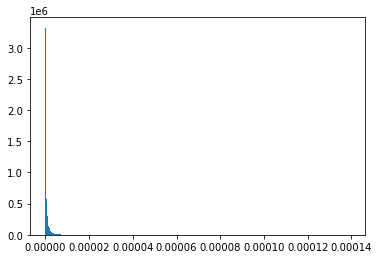

In [28]:
plt.hist(df_nn_all['diff2'], bins=1000)
plt.show()

In [29]:
df_nn_filtered = filtered_nn_aligned_dist(df_nn_all, candidates_union)
df_nn_filtered.head()

manifold aligned # of L-R pairs: 817


,idx,dist,rank,correspondence_score,idx,dist,rank,correspondence_score,diff2,diff2_rank,rank_filtered
Il33_Il1rl1,"(862, 1891)",0.004410,199308,8.879311,"(862, 1891)",0.015893,3542526,7.280742e-24,0.000132,744,1
Edn1_Ednrb,"(604, 363)",0.010369,1211076,1.031674,"(604, 363)",0.014721,2933367,8.028428e-02,0.000019,4266,2
Edn3_Ednrb,"(2089, 363)",0.010703,1324434,0.709435,"(2089, 363)",0.015019,3082778,5.520779e-02,0.000019,4613,3
Csf2_Tnf,"(142, 365)",0.006923,461854,3.329928,"(142, 365)",0.010881,1185360,2.481270e-01,0.000016,11564,4
Csf1_Tnf,"(1041, 365)",0.008673,765565,2.216438,"(1041, 365)",0.012616,1904945,1.651562e-01,0.000016,11947,5


In [30]:
df_enriched_diff = chi2_diff_test(df_nn_all, df=1, FDR=False, candidates=candidates_union)
df_enriched_diff


Total enriched: 23 / 9000000


,idx,dist,rank,correspondence_score,idx,dist,rank,correspondence_score,diff2,diff2_rank,p_val,enriched_rank
Il33_Il1rl1,"(862, 1891)",0.004410,199308,8.879311,"(862, 1891)",0.015893,3542526,7.280742e-24,0.000132,744,0.000000,1
Edn1_Ednrb,"(604, 363)",0.010369,1211076,1.031674,"(604, 363)",0.014721,2933367,8.028428e-02,0.000019,4266,0.000002,2
Edn3_Ednrb,"(2089, 363)",0.010703,1324434,0.709435,"(2089, 363)",0.015019,3082778,5.520779e-02,0.000019,4613,0.000003,3
Csf2_Tnf,"(142, 365)",0.006923,461854,3.329928,"(142, 365)",0.010881,1185360,2.481270e-01,0.000016,11564,0.000018,4
Csf1_Tnf,"(1041, 365)",0.008673,765565,2.216438,"(1041, 365)",0.012616,1904945,1.651562e-01,0.000016,11947,0.000020,5
Stc1_Tnf,"(2086, 365)",0.008297,689984,2.139763,"(2086, 365)",0.012230,1729672,1.594428e-01,0.000015,12312,0.000021,6
Angpt1_Tnf,"(1122, 365)",0.010416,1226690,0.734972,"(1122, 365)",0.014315,2724407,5.476590e-02,0.000015,13532,0.000024,7
Icam1_Muc1,"(461, 135)",0.008515,733267,2.708103,"(461, 135)",0.011494,1414982,1.636299e-01,0.000009,49896,0.001260,8
Thbs1_Cd36,"(121, 505)",0.004289,190529,5.272272,"(121, 505)",0.007095,407596,1.236436e+00,0.000008,74660,0.002389,9
S100a9_Cd36,"(8, 505)",0.007913,618556,1.582454,"(8, 505)",0.010609,1102325,3.711120e-01,0.000007,89145,0.003522,10


#### GSEA:

In [31]:
genelist = get_genelist(df_enriched_diff)
len(genelist)

30

In [33]:
import gseapy as gp

enr = gp.enrichr(gene_list= genelist,
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [34]:
enr.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,positive regulation of leukocyte chemotaxis (G...,8/54,9.177136e-15,5.944353e-12,0,0,157.501976,5090.788521,IL6;EDN3;CSF1;MDK;RARRES2;CCL5;PTN;THBS1
1,GO_Biological_Process_2021,positive regulation of leukocyte migration (GO...,7/29,1.224377e-14,5.944353e-12,0,0,275.960474,8840.051260,IL6;CSF1;EDN3;MDK;PTN;TNF;ICAM1
2,GO_Biological_Process_2021,positive regulation of response to external st...,9/139,3.678383e-13,1.190570e-10,0,0,65.406593,1872.664870,IL33;MDK;RARRES2;CCL5;PTN;S100A9;TNF;THBS1;S100A8
3,GO_Biological_Process_2021,regulation of mononuclear cell migration (GO:0...,6/23,6.628710e-13,1.609119e-10,0,0,293.426471,8228.322607,CSF1;MDK;RARRES2;CCL5;THBS1;TNF
4,GO_Biological_Process_2021,positive regulation of cellular process (GO:00...,13/625,1.760189e-12,3.418287e-10,0,0,24.188197,654.668062,EDN1;CSF2;EDN3;CSF1;PTN;TNF;THBS1;IL6;MDK;CCL5...


https://maayanlab.cloud/Enrichr/enrich?dataset=983557128e2439ce19c24f8a2ea1ed2b

#### visualization:

In [35]:
Xct.add_names_to_nets(obj1)
Xct.add_names_to_nets(obj2)

completed.
completed.


In [36]:
targets = vis.get_Xct_pairs(df_enriched_diff)
targets

(['Il33', 'Il1rl1'],
 ['Edn1', 'Ednrb'],
 ['Edn3', 'Ednrb'],
 ['Csf2', 'Tnf'],
 ['Csf1', 'Tnf'],
 ['Stc1', 'Tnf'],
 ['Angpt1', 'Tnf'],
 ['Icam1', 'Muc1'],
 ['Thbs1', 'Cd36'],
 ['S100a9', 'Cd36'],
 ['S100a8', 'Cd36'],
 ['Tnf', 'Muc1'],
 ['Thbs1', 'Ltbp1'],
 ['Angptl4', 'Gpihbp1'],
 ['Csf1', 'Msr1'],
 ['Il6', 'Msr1'],
 ['Tek', 'Ptprb'],
 ['Tnf', 'Cd83'],
 ['Rarres2', 'Ccrl2'],
 ['Ccl5', 'Ccrl2'],
 ['Mdk', 'Ptprb'],
 ['Tnc', 'Ptprb'],
 ['Ptn', 'Ptprb'])

In [ ]:
# targets_inter = set(df_enriched_diff.index).intersection(set(candidates_inter))
# targets_inter = [pair.split('_') for pair in targets_inter]

# targets_inter

In [37]:
scale_factor = 10

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

graphs merged: 
# of nodes: 42, # of edges: 40

edge from Il33 to Il1rl1 added


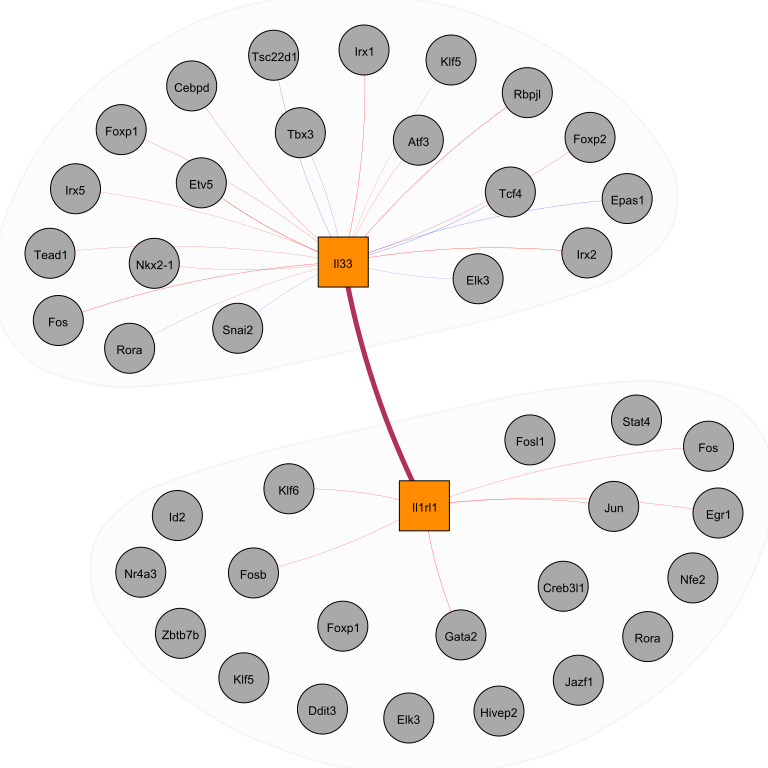

In [38]:
import random
random.seed(0)

g1 = vis.plot_pcNet(obj1, view='sender', gene_names=[targets[0][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', gene_names=[targets[0][1]], top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[0]], verbose = True, edge_width_scale=scale_factor)

In [40]:
g1 = vis.plot_pcNet(obj2, view='sender', gene_names=[targets[0][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj2, view='receiver', gene_names=[targets[0][1]], top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[0]], verbose = True, edge_width_scale=scale_factor)

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 137 TF(s) along with 1 ligand/receptor target gene(s)


ValueError: target gene Il1rl1 generated 0 edge, stoped...

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20



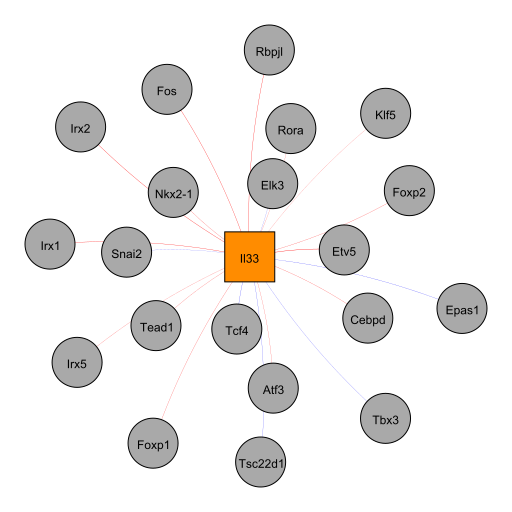

In [42]:
vis.plot_pcNet(obj2, view='sender', gene_names=[targets[0][0]], top_edges=20, show = True, verbose = True, 
               edge_width_scale=scale_factor)